In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import time
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder


In [2]:
df = pd.read_csv("Trips_2018.csv")

#Remove unwanted index column if it exists
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

#Convert start and stop times to proper datetime format
df["starttime"] = pd.to_datetime(df["starttime"], errors="coerce")
df["stoptime"]  = pd.to_datetime(df.get("stoptime"), errors="coerce")


#Create a new column 'start_hour' — the trip’s start time rounded down to the hour (used later to join with hourly weather data)
df["start_hour"] = df["starttime"].dt.floor("H")

#Compute trip duration in minutes
df["trip_duration_min"] = (
    df["tripduration"]/60.0
    if "tripduration" in df.columns
    else (df["stoptime"] - df["starttime"]).dt.total_seconds()/60
)

#Find a representative latitude and longitude for weather data Using median coordinates ensures one central location (e.g., NYC center)
LAT, LON = df["start_station_latitude"].median(), df["start_station_longitude"].median()

#Find the overall date range of the dataset for API query
START = df["start_hour"].min().date().isoformat()
END   = df["start_hour"].max().date().isoformat()

#Print a quick summary
print(f"Trips: {len(df)}  |  Date span: {START} → {END}")
df.head()

C:\Users\Akhil\AppData\Local\Temp\ipykernel_7732\901575409.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["start_hour"] = df["starttime"].dt.floor("H")


Trips: 17548339  |  Date span: 2018-01-01 → 2018-12-31


,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,start_hour,trip_duration_min
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1,2018-01-01 13:00:00,16.166667
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1,2018-01-01 15:00:00,12.050000
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1,2018-01-01 15:00:00,8.266667
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1,2018-01-01 15:00:00,5.100000
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1,2018-01-01 18:00:00,5.100000


In [3]:
# --- Weather by small spatial grid (fast, robust, with fallback) ---
stations = df[["start_station_id", "start_station_latitude", "start_station_longitude"]].drop_duplicates()

# 1) Build a small grid (≈2–3 km) to reduce API calls
GRID = 0.03  # ↑ 0.05 fewer calls, ↓ 0.02 more detail

stations = stations.copy()
stations["lat_bin"] = (stations["start_station_latitude"]  / GRID).round().astype(int)
stations["lon_bin"] = (stations["start_station_longitude"] / GRID).round().astype(int)
stations["cell_id"] = stations["lat_bin"].astype(str) + "_" + stations["lon_bin"].astype(str)

cells = (stations.groupby("cell_id", as_index=False)
         .agg(lat=("start_station_latitude", "median"),
              lon=("start_station_longitude", "median")))

print(f"Unique grid cells to fetch: {len(cells)}")


# 2) Helper: polite, retrying fetch per cell
def fetch_cell(lat, lon, start_date, end_date, retries=5, pause=1.5):
    url = "https://archive-api.open-meteo.com/v1/era5"
    hourly_vars = [
        "temperature_2m","apparent_temperature","rain","snowfall",
        "wind_speed_10m","relative_humidity_2m","cloud_cover","visibility"
    ]
    params = {
        "latitude": float(lat), "longitude": float(lon),
        "start_date": start_date, "end_date": end_date,
        "timezone": "America/New_York",
        "hourly": ",".join(hourly_vars)  # more robust than list for some clients
    }
    last_err = None
    for a in range(retries):
        try:
            resp = requests.get(url, params=params, timeout=40)
            if resp.ok:
                js = resp.json()
                if "hourly" in js:
                    wx = pd.DataFrame(js["hourly"])
                    wx["start_hour"] = pd.to_datetime(wx["time"])
                    wx = wx.drop(columns=["time"])
                    # downcast floats to save memory
                    for c in wx.columns:
                        if c != "start_hour" and pd.api.types.is_float_dtype(wx[c]):
                            wx[c] = pd.to_numeric(wx[c], downcast="float")
                    return wx
                else:
                    last_err = f"no 'hourly' in response (keys={list(js.keys())})"
            else:
                last_err = f"HTTP {resp.status_code}: {resp.text[:160]}"
        except Exception as e:
            last_err = str(e)
        time.sleep(pause * (a + 1))  # gentle backoff
    # Uncomment for debugging:
    # print(f"Fetch failed for ({lat:.4f},{lon:.4f}): {last_err}")
    return None


# 3) Fetch once per cell
cell_weather, failed_cells = [], []
for _, r in cells.iterrows():
    wx_cell = fetch_cell(r["lat"], r["lon"], START, END)
    if wx_cell is None:
        failed_cells.append(r["cell_id"])
        continue
    wx_cell["cell_id"] = r["cell_id"]
    cell_weather.append(wx_cell)
    time.sleep(0.2)  # pacing

# --- Fallback if everything failed: use single (city-median) point ---
if not cell_weather:
    print("⚠️ All grid cells failed. Falling back to city-median weather…")
    lat0 = float(df["start_station_latitude"].median())
    lon0 = float(df["start_station_longitude"].median())
    wx_city = fetch_cell(lat0, lon0, START, END)
    if wx_city is None:
        raise RuntimeError(
            f"No weather fetched even for city median. Check network/date range. START={START}, END={END}"
        )
    wx_city["cell_id"] = "city_median"
    wx_cells = wx_city.copy()
    stations2 = stations.copy()
    stations2["use_cell"] = "city_median"
else:
    wx_cells = pd.concat(cell_weather, ignore_index=True)
    print(f"Weather rows (cells): {len(wx_cells)} | cells covered: {wx_cells['cell_id'].nunique()}")

    # 4) If some cells failed, borrow weather from nearest fetched cell
    if failed_cells:
        print("Filling missing cells from nearest fetched cell…")

        have = cells[cells["cell_id"].isin(wx_cells["cell_id"].unique())].copy()
        need = cells[cells["cell_id"].isin(failed_cells)].copy()

        def haversine(lat1, lon1, lat2, lon2):
            R = 6371.0
            lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2))
            dlat, dlon = lat2 - lat1, lon2 - lon1
            a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
            return 2 * R * np.arcsin(np.sqrt(a))

        alias_rows = []
        H_lat = have["lat"].to_numpy()
        H_lon = have["lon"].to_numpy()
        for _, r in need.iterrows():
            d = haversine(r["lat"], r["lon"], H_lat, H_lon)
            nearest = have.iloc[d.argmin()]["cell_id"]
            alias_rows.append((r["cell_id"], nearest))
        alias = pd.DataFrame(alias_rows, columns=["cell_id", "use_cell"])
    else:
        alias = pd.DataFrame(columns=["cell_id", "use_cell"])

    # Stations use their own cell if fetched, otherwise the nearest fetched cell
    stations2 = stations.merge(alias, on="cell_id", how="left")
    stations2["use_cell"] = stations2["use_cell"].fillna(stations2["cell_id"])

# 5) Expand cell weather back to stations
wx = (stations2[["start_station_id", "use_cell"]]
      .rename(columns={"use_cell": "cell_id"})
      .merge(wx_cells, on="cell_id", how="left"))

print("Total weather rows (expanded to stations):", len(wx))


Unique grid cells to fetch: 26
Weather rows (cells): 227760 | cells covered: 26
Total weather rows (expanded to stations): 8050440


In [4]:
# === Merge trips with hourly weather ===

is_station_level = "start_station_id" in wx.columns
key_cols = ["start_hour"] + (["start_station_id"] if is_station_level else [])

print("Merging on:", key_cols)

# keep only weather fields we actually need (saves memory) if present
wanted_wx = [
    "start_hour", "start_station_id",
    "temperature_2m","apparent_temperature","rain","snowfall",
    "wind_speed_10m","relative_humidity_2m","cloud_cover","visibility"
]
wx_keyed = wx[[c for c in wanted_wx if c in wx.columns]].drop_duplicates(subset=key_cols)

dfm = df.merge(
    wx_keyed,
    on=key_cols,
    how="left",          # keep all trips/columns from df
    validate="m:1"       # many trips to one weather row
)

# merge quality
miss_pct = dfm["temperature_2m"].isna().mean() * 100
print(f"Merge complete | rows={len(dfm):,} | weather coverage={100 - miss_pct:.1f}%")

dfm.head()

Merging on: ['start_hour', 'start_station_id']
Merge complete | rows=17,548,339 | weather coverage=100.0%


,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,...,start_hour,trip_duration_min,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,relative_humidity_2m,cloud_cover,visibility
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,...,2018-01-01 13:00:00,16.166667,-8.1,-14.9,0.0,0.0,20.400000,30,0,None
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,...,2018-01-01 15:00:00,12.050000,-6.9,-13.7,0.0,0.0,19.700001,24,55,None
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,...,2018-01-01 15:00:00,8.266667,-6.9,-13.7,0.0,0.0,19.700001,24,55,None
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,...,2018-01-01 15:00:00,5.100000,-6.9,-13.7,0.0,0.0,19.700001,24,55,None
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,...,2018-01-01 18:00:00,5.100000,-10.0,-15.0,0.0,0.0,7.400000,39,23,None


In [5]:
# === Feature engineering: concise, robust, memory-friendly ===

need = ["temperature_2m","rain","snowfall","wind_speed_10m","cloud_cover","visibility"]
for c in need:
    if c not in dfm.columns:
        dfm[c] = np.nan
dfm[need] = dfm[need].apply(pd.to_numeric, errors="coerce")

# 1) Temperature (°C) + readable buckets
dfm["temp_celsius"] = dfm["temperature_2m"]
dfm["temp_category"] = pd.cut(
    dfm["temp_celsius"],
    bins=[-99, 0, 10, 20, 25, 30, 99],
    labels=["freezing","cold","cool","comfortable","warm","hot"]
)

# 2) Dryness (1 dry, 0 wet)
rain  = dfm["rain"].fillna(0)
snow  = dfm["snowfall"].fillna(0)
dfm["is_dry"] = ((rain + snow) == 0).astype("int8")

# 3) Wind, sky, visibility
dfm["wind_kmh"] = dfm["wind_speed_10m"] * 3.6
dfm["sky_condition"] = pd.cut(
    dfm["cloud_cover"],
    bins=[-1, 25, 50, 75, 100.1],
    labels=["clear","partly_cloudy","cloudy","overcast"]
)
dfm["visibility_km"] = dfm["visibility"] / 1000.0

# 4) Cycling Score (0–100): temp comfort 40% + dryness 30% + low wind 20% + visibility 10%
dfm["cycling_score"] = (
    np.exp(-((dfm["temp_celsius"] - 20) / 10) ** 2) * 40           # temperature comfort peak ~20°C
    + dfm["is_dry"] * 30                                           # dry bonus
    + (dfm["wind_kmh"] < 20).astype("int8") * 20                   # calm wind
    + (dfm["visibility_km"] > 5).astype("int8") * 10               # clear view
).clip(0, 100)

# 5) Compact memory for categories
dfm["temp_category"] = dfm["temp_category"].astype("category")
dfm["sky_condition"]  = dfm["sky_condition"].astype("category")

print(f"Weather features added | shape={dfm.shape} | new cols: "
      f"['temp_celsius','temp_category','is_dry','wind_kmh','sky_condition','visibility_km','cycling_score']")
dfm.head()


Weather features added | shape=(17548339, 30) | new cols: ['temp_celsius','temp_category','is_dry','wind_kmh','sky_condition','visibility_km','cycling_score']


,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,...,relative_humidity_2m,cloud_cover,visibility,temp_celsius,temp_category,is_dry,wind_kmh,sky_condition,visibility_km,cycling_score
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,...,30,0,NaN,-8.1,freezing,1,73.439995,clear,NaN,30.014887
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,...,24,55,NaN,-6.9,freezing,1,70.919998,cloudy,NaN,30.028805
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,...,24,55,NaN,-6.9,freezing,1,70.919998,cloudy,NaN,30.028805
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,...,24,55,NaN,-6.9,freezing,1,70.919998,cloudy,NaN,30.028805
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,...,39,23,NaN,-10.0,freezing,1,26.639999,clear,NaN,30.004936


In [6]:
# === Frequent station discovery with Apriori ===
#
start_options = [c for c in ("start_station_name", "start_station_id") if c in dfm.columns]
end_options = [c for c in ("end_station_name", "end_station_id") if c in dfm.columns]
if not start_options or not end_options:
    raise ValueError("Station columns required for Apriori analysis are missing from dfm.")
start_col, end_col = start_options[0], end_options[0]

trip_pairs = dfm[[start_col, end_col]].dropna().astype(str)
total_trips = len(trip_pairs)
print(f"Total trips for Apriori analysis: {total_trips:,}")
if total_trips == 0:
    raise ValueError("No trips remain after dropping rows with missing station identifiers.")
transactions = trip_pairs.apply(lambda row: [f"start::{row[start_col]}", f"end::{row[end_col]}"] , axis=1).tolist()

route_counts = (
    trip_pairs.groupby([start_col, end_col])
    .size()
    .reset_index(name="trip_count")
    .sort_values("trip_count", ascending=False)
)
route_counts["support"] = route_counts["trip_count"] / total_trips

te = TransactionEncoder()
encoded = te.fit(transactions).transform(transactions, sparse=True)
onehot = pd.DataFrame.sparse.from_spmatrix(encoded, columns=te.columns_)

target_support = 0.01
support_floor = max(0.00005, 1 / total_trips)
support_factor = 0.5  
current_support = target_support
effective_support = None
freq_itemsets = pd.DataFrame()

while current_support >= support_floor and freq_itemsets.empty:
    freq_itemsets = apriori(onehot, min_support=current_support, use_colnames=True)
    if not isinstance(freq_itemsets, pd.DataFrame):
        freq_itemsets = pd.DataFrame(freq_itemsets)
    if "itemsets" not in freq_itemsets.columns:
        freq_itemsets = freq_itemsets.copy()
        freq_itemsets["itemsets"] = freq_itemsets.index
    if freq_itemsets.empty:
        current_support *= support_factor
    else:
        effective_support = current_support

if freq_itemsets.empty:
    print(
        f"No frequent itemsets found even at min_support={support_floor:.5f}. "
        "Increase trip counts, widen the window, or rely on direct route counts below."
    )
    pair_itemsets = pd.DataFrame(columns=["start_station", "end_station", "support"])
    single_itemsets = pd.DataFrame(columns=["role", "station", "support"])
    min_support = support_floor
else:
    min_support = effective_support

    def is_start_end_pair(itemset):
        if len(itemset) != 2:
            return False
        has_start = any(item.startswith("start::") for item in itemset)
        has_end = any(item.startswith("end::") for item in itemset)
        return has_start and has_end

    pair_itemsets = freq_itemsets[freq_itemsets["itemsets"].apply(is_start_end_pair)].copy()
    pair_itemsets["start_station"] = pair_itemsets["itemsets"].apply(lambda s: next(item.split("::", 1)[1] for item in s if item.startswith("start::")))
    pair_itemsets["end_station"] = pair_itemsets["itemsets"].apply(lambda s: next(item.split("::", 1)[1] for item in s if item.startswith("end::")))
    pair_itemsets = pair_itemsets[["start_station", "end_station", "support"]].sort_values("support", ascending=False)

    single_itemsets = freq_itemsets[freq_itemsets["itemsets"].apply(lambda s: len(s) == 1)].copy()
    single_itemsets["role"] = single_itemsets["itemsets"].apply(lambda s: "start" if next(iter(s)).startswith("start::") else "end")
    single_itemsets["station"] = single_itemsets["itemsets"].apply(lambda s: next(iter(s)).split("::", 1)[1])
    single_itemsets = single_itemsets[["role", "station", "support"]].sort_values(["role", "support"], ascending=[True, False])

print(
    f"Pairs found (Apriori): {len(pair_itemsets)} | Stations found: {len(single_itemsets)} | "
    f"effective min_support={min_support:.5f} | total trips={total_trips:,}"
 )
if pair_itemsets.empty:
    print("No frequent start→end pairs met the Apriori support threshold.")
else:
    display(pair_itemsets.head(10))
if single_itemsets.empty:
    print("No frequent individual stations met the Apriori support threshold.")
else:
    display(single_itemsets.groupby("role").head(5))

top_routes = route_counts.copy()
if not pair_itemsets.empty:
    top_routes = top_routes.merge(
        pair_itemsets.rename(columns={"support": "apriori_support"}).assign(
            start_station=lambda d: d["start_station"].astype(str),
            end_station=lambda d: d["end_station"].astype(str),
        ),
        left_on=[start_col, end_col],
        right_on=["start_station", "end_station"],
        how="left"
    ).drop(columns=["start_station", "end_station"], errors="ignore")

print("\nTop observed station-to-station routes (by trip count):")
display(top_routes.head(15))

Total trips for Apriori analysis: 17,545,842


C:\Users\Akhil\AppData\Local\Temp\ipykernel_7732\2330978338.py:26: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  onehot = pd.DataFrame.sparse.from_spmatrix(encoded, columns=te.columns_)


Pairs found (Apriori): 0 | Stations found: 14 | effective min_support=0.00500 | total trips=17,545,842
No frequent start→end pairs met the Apriori support threshold.


,role,station,support
6,end,519.0,0.008545
5,end,497.0,0.006459
1,end,402.0,0.006221
3,end,435.0,0.006192
2,end,426.0,0.005666
13,start,519.0,0.008564
12,start,497.0,0.006206
10,start,435.0,0.006108
8,start,402.0,0.006019
9,start,426.0,0.005384



Top observed station-to-station routes (by trip count):


,start_station_id,end_station_id,trip_count,support
11944,2006.0,2006.0,7852,0.000448
291063,432.0,3263.0,7249,0.000413
37781,281.0,281.0,6344,0.000362
12112,2006.0,3282.0,6215,0.000354
304346,460.0,3093.0,5456,0.000311
69108,3093.0,460.0,5137,0.000293
292656,435.0,509.0,4996,0.000285
334240,519.0,492.0,4663,0.000266
334246,519.0,498.0,4465,0.000254
272318,387.0,387.0,4464,0.000254


No Apriori start→end station pairs to plot.


C:\Users\Akhil\AppData\Local\Temp\ipykernel_7732\3963341903.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=observed, y="pair", x="trip_count", palette="Oranges_r", ax=ax)


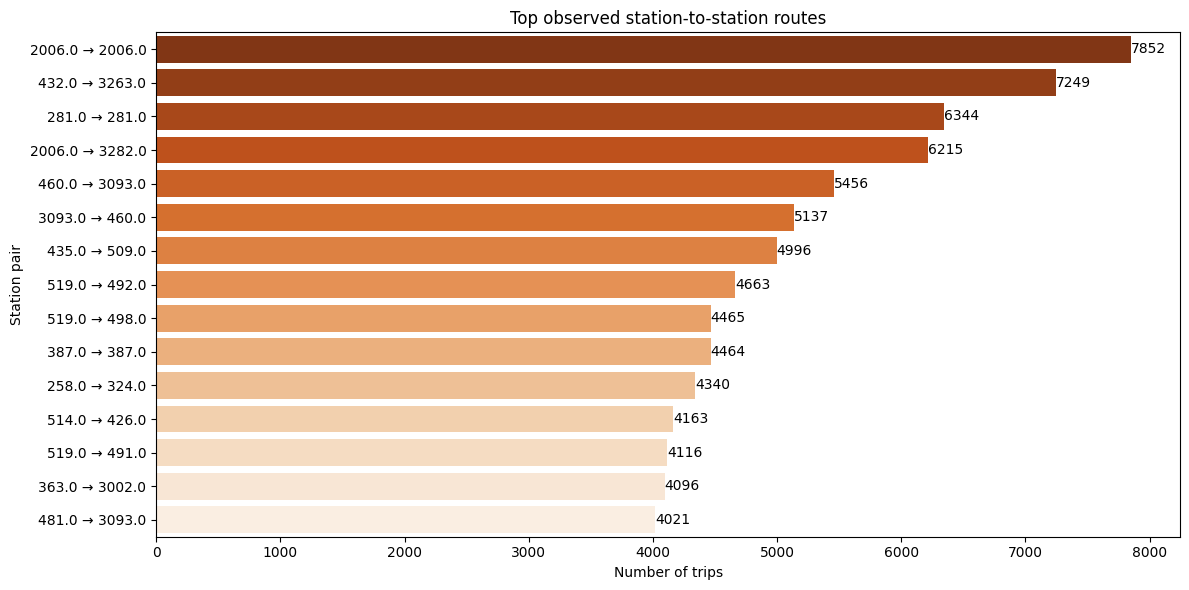

C:\Users\Akhil\AppData\Local\Temp\ipykernel_7732\3963341903.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, y="station", x="support", palette=palette, ax=ax)
C:\Users\Akhil\AppData\Local\Temp\ipykernel_7732\3963341903.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, y="station", x="support", palette=palette, ax=ax)


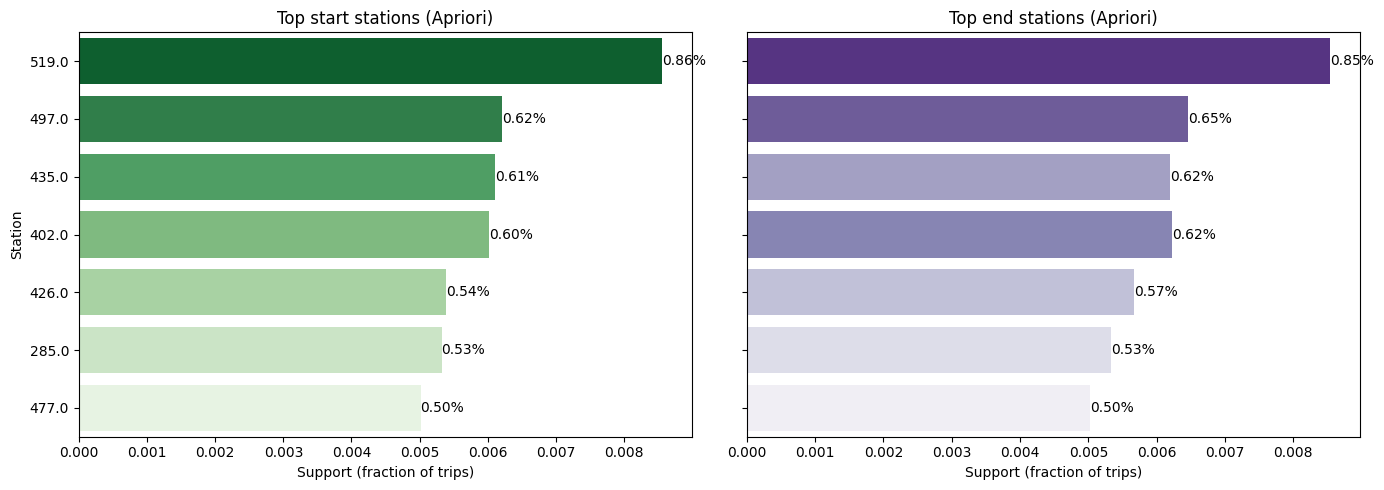

In [7]:
# === Plot frequent station patterns ===
if "pair_itemsets" not in locals() or "single_itemsets" not in locals():
    raise NameError("Run the Apriori cell first to build pair_itemsets and single_itemsets.")
if "top_routes" not in locals():
    raise NameError("Run the Apriori cell first to compute top_routes.")

if pair_itemsets.empty and single_itemsets.empty and top_routes.empty:
    raise ValueError("No frequent stations or pairs available to plot; adjust filters and rerun Apriori cell.")

if not pair_itemsets.empty:
    top_pairs = pair_itemsets.head(15).copy()
    top_pairs["pair"] = top_pairs["start_station"] + " → " + top_pairs["end_station"]

    fig, ax = plt.subplots(figsize=(12, 6))
    sns.barplot(data=top_pairs, y="pair", x="support", palette="Blues_r", ax=ax)
    ax.set_title("Top frequent start→end station pairs (Apriori)")
    ax.set_xlabel("Support (fraction of trips)")
    ax.set_ylabel("Station pair")
    for container in ax.containers:
        ax.bar_label(container, fmt="{:.2%}")
    plt.tight_layout()
    plt.show()
else:
    print("No Apriori start→end station pairs to plot.")

if not top_routes.empty:
    observed = top_routes.head(15).copy()
    observed["pair"] = observed[start_col].astype(str) + " → " + observed[end_col].astype(str)
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.barplot(data=observed, y="pair", x="trip_count", palette="Oranges_r", ax=ax)
    ax.set_title("Top observed station-to-station routes")
    ax.set_xlabel("Number of trips")
    ax.set_ylabel("Station pair")
    for container in ax.containers:
        ax.bar_label(container, fmt="{:.0f}")
    plt.tight_layout()
    plt.show()
else:
    print("No observed routes to plot.")

available_roles = [role for role in ["start", "end"] if not single_itemsets[single_itemsets["role"] == role].empty]
if available_roles:
    fig, axes = plt.subplots(1, len(available_roles), figsize=(7 * len(available_roles), 5), sharey=True)
    if len(available_roles) == 1:
        axes = [axes]
    for ax, role in zip(axes, available_roles):
        subset = single_itemsets[single_itemsets["role"] == role].head(15).copy()
        palette = "Greens_r" if role == "start" else "Purples_r"
        sns.barplot(data=subset, y="station", x="support", palette=palette, ax=ax)
        ax.set_title(f"Top {role} stations (Apriori)")
        ax.set_xlabel("Support (fraction of trips)")
        for container in ax.containers:
            ax.bar_label(container, fmt="{:.2%}")
    axes[0].set_ylabel("Station")
    if len(available_roles) == 2:
        axes[1].set_ylabel("")
    plt.tight_layout()
    plt.show()
else:
    print("No frequent start or end stations (Apriori) to plot.")